优化SVM分类器

机器学习模型是参数化的，因此它们的行为可以针对给定的问题进行调整。
模型可以有许多参数，寻找参数的最佳组合可以被视为一个搜索问题。
在本笔记本中，我的目标是使用scikit-learn调整SVM分类模型的参数。

5.1加载库和数据


分类器的准确率得分为96.49%


该分类器的3-fold交叉验证准确率得分为97.36%


该分类器的5-fold交叉验证准确率得分为 97.36%

[[107   0]
 [  6  58]]


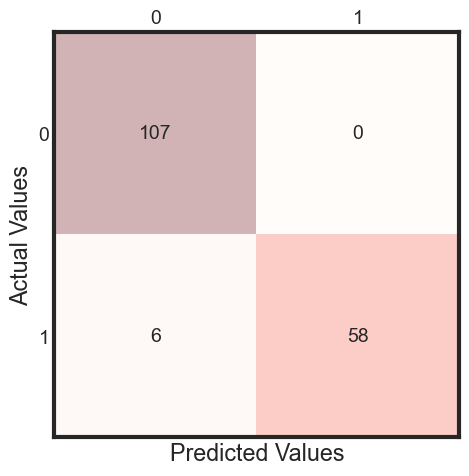

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

#加载库进行数据处理
import pandas as pd
import numpy as np
from scipy.stats import norm

#监督学习
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
#可视化
import seaborn as sns 
plt.style.use('fivethirtyeight')
sns.set_style("white")

plt.rcParams['figure.figsize'] = (10,8) 
data = pd.read_csv('data/data.csv')
#数据预处理
X = data.iloc[:,2:32] # 特征
y = data.iloc[:,1] # 标签
from sklearn.preprocessing import StandardScaler
le = LabelEncoder()
y = le.fit_transform(y)

#规范化数据(以0为中心并缩放以消除方差)。
scaler =StandardScaler()
Xs = scaler.fit_transform(X)
from sklearn.decomposition import PCA
#特征提取
pca = PCA(n_components=10)
fit = pca.fit(Xs)
X_pca = pca.transform(Xs)
#在训练集和测试集中划分记录。
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=33, stratify=y)
#创建一个SVM分类器并在70%的数据集上训练它。
clf = SVC(probability=True)
clf.fit(X_train, y_train)
#分析30%的拒绝测试样本的预测准确性。
classifier_score = clf.score(X_test, y_test)*100
print('\n分类器的准确率得分为{:03.2f}%\n'.format(classifier_score))
from sklearn.feature_selection import SelectKBest, f_regression
clf2 = make_pipeline(SelectKBest(f_regression, k=3),SVC(probability=True))

scores = cross_val_score(clf2, Xs, y, cv=3)

#使用SVC估计器获得3倍交叉验证分数的平均值。
n_folds = 3
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))*100
print('\n该分类器的{}-fold交叉验证准确率得分为{:.2f}%\n'.format(n_folds, cv_error))
#使用SVC估计器获得3倍交叉验证分数的平均值。
n_folds = 5
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))*100
print('\n该分类器的{}-fold交叉验证准确率得分为 {:.2f}%\n'.format(n_folds, cv_error))
#混淆矩阵有助于可视化算法的性能。
y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Image, display

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()
print(classification_report(y_test, y_pred ))

5.2优化分类器的重要性

我们可以调整SVM算法的两个关键参数:C的值(放宽多少余量)和核的类型。
SVM (SVC类)的默认值是使用径向基函数(RBF)内核，其C值设置为1.0。与KNN一样，
我将使用训练数据集的标准化副本执行10倍交叉验证的网格搜索。
我将尝试一些更简单的内核类型和具有较小偏差和较大偏差(分别小于和大于1.0)的C值。
Python scikit-learn提供了两种简单的算法参数调优方法:
1.网格搜索参数调优。
2.随机搜索参数优化。

In [2]:
#训练分类器
kernel_values = [ 'linear' ,  'poly' ,  'rbf' ,  'sigmoid' ]
param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6),'kernel': kernel_values}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [3]:
print("最好的参数是%s，分数为%0.2f"% (grid.best_params_, grid.best_score_))

最好的参数是{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}，分数为0.98


In [4]:
grid.best_estimator_.probability = True
clf = grid.best_estimator_

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



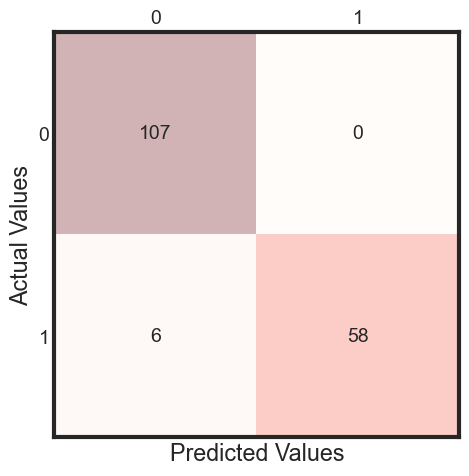

In [5]:

y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
#print(cm)
print(classification_report(y_test, y_pred ))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()


5.3不同分类器的决策边界

让我们看看由线性、高斯和多项式分类器产生的决策边界。

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm, datasets

def decision_plot(X_train, y_train, n_neighbors, weights):
       h = .02  # 网格中的步长

Xtrain = X_train[:, :2] #我们只取前两个特征。

# 创造颜色地图
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

#我创建一个SVM实例并拟合数据。不缩放数据，因为想绘制支持向量

C = 1.0  #支持向量机正则化参数

svm = SVC(kernel='linear', random_state=0, gamma=0.1, C=C).fit(Xtrain, y_train)#linear线性核
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(Xtrain, y_train)#rbf高斯核函数
poly_svc = SVC(kernel='poly', degree=3, C=C).fit(Xtrain, y_train)#poly多项式
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5).fit(Xtrain, y_train)#K近邻算法 (K-Nearest Neighbors, KNN)
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=5).fit(Xtrain, y_train)#决策树 (Decision Tree)
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(Xtrain, y_train)#随机森林 (Random Forest)
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB().fit(Xtrain, y_train)#朴素贝叶斯 (Naive Bayes)
from sklearn.neural_network import MLPClassifier
neural_network = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500).fit(Xtrain, y_train)#神经网络 (Neural Network)
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression().fit(Xtrain, y_train)#逻辑回归LR


In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9) 
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False    
#创建一个网格来绘制
x_min, x_max = Xtrain[:, 0].min() - 1, Xtrain[:, 0].max() + 1
y_min, y_max = Xtrain[:, 1].min() - 1, Xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

# 图标题
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
          'knn','decision_tree','random_forest','naive_bayes','neural_network','Logistic Regression'
         ]
plt.figure(figsize=(15, 15))  # 调整画布大小

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

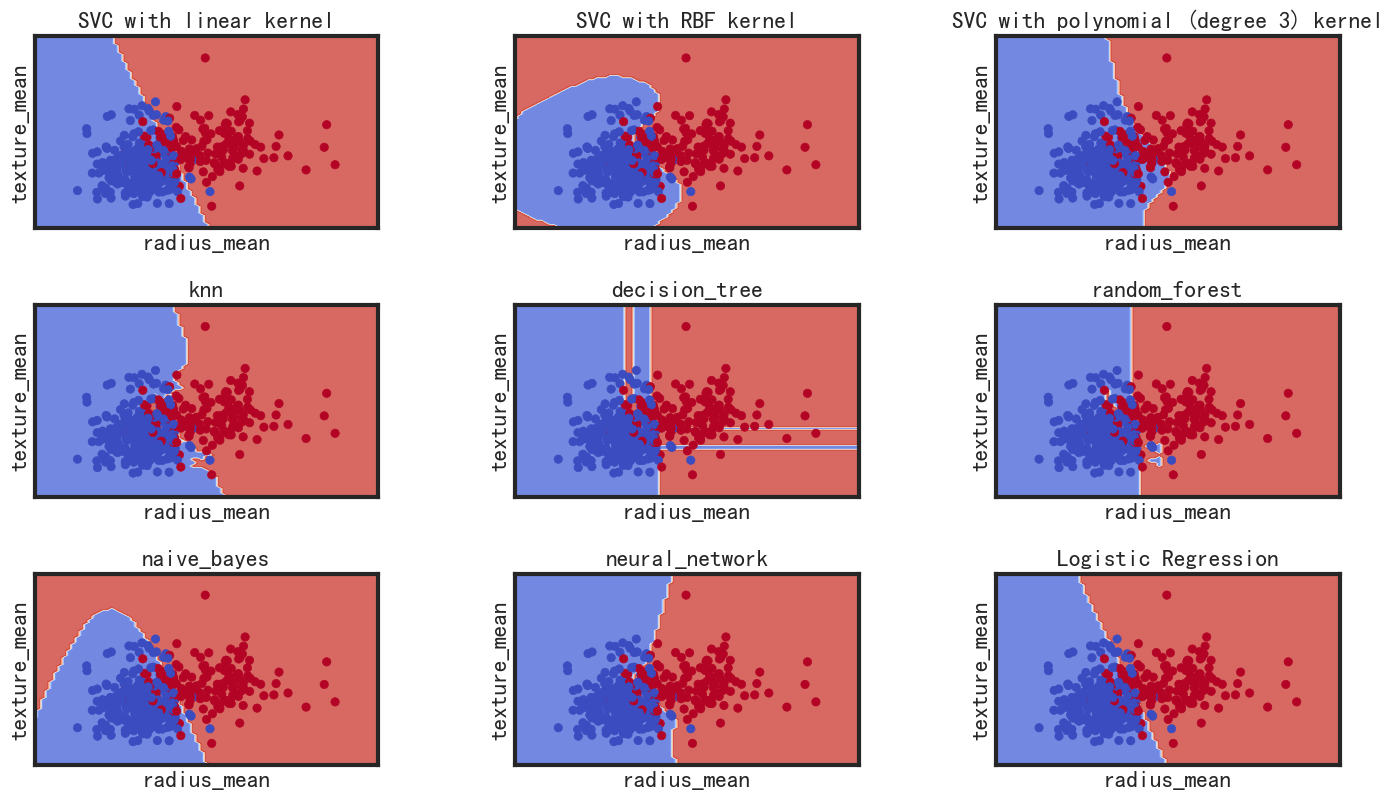

In [8]:
for i, clf in enumerate((svm, rbf_svc, poly_svc,knn,decision_tree,random_forest,naive_bayes,neural_network,logistic_regression)):
   #绘制决策边界。为此，我们将为网格[x_min, x_max]x[y_min, y_max]中的每个点分配一个颜色。
    plt.subplot(3, 3, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    #将结果放入彩色图中
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    #绘制训练点
    plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=y_train, cmap=plt.cm.coolwarm)
    plt.xlabel('radius_mean')
    plt.ylabel('texture_mean')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

结论
本工作证明了使用支持向量机将乳腺癌建模为分类任务。
当数据集标准化时，支持向量机的性能更好，所有属性的平均值为零，标准差为1。
我们可以从整个训练数据集中计算这个值，并对验证数据集中的输入属性应用相同的转换。